In [1]:
import warnings


import pandas as pd

import pylab as pl
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime

from sklearn import preprocessing
from sklearn import cross_validation

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
#defining function to read data 
def read_training_data(data_files):
    
    age_gender = pd.read_csv(data_files['age_gender'])
    countries = pd.read_csv(data_files['countries'])
    sessions = pd.read_csv(data_files['sessions'])
    train_users = pd.read_csv(data_files['users'])
    
    return age_gender, countries, sessions, train_users

#def

In [3]:
data_files = {'age_gender':'data/age_gender_bkts.csv',
'countries':'data/countries.csv',
'sessions':'data/sessions.csv',
'users':'data/train_users_2.csv'}

In [4]:
#general data wrangling
def clean_up(dataframe):

    #dealing with missing data
    dataframe.replace("-unknown-", np.nan, inplace = True)
    new_timestamp = dataframe.timestamp_first_active.astype(str)
    dates = pd.to_datetime(pd.Series([datetime.strptime(date, '%Y%m%d%H%M%S') for date in new_timestamp]))
    
    # replace age in areas where it doesn't make sense with -1
    av = dataframe.age.values
    dataframe['age'] = np.where(np.logical_or(av<14, av>100), -1, av)
    
    #replacing datetime objects which are more difficult to work with
    dataframe['timestamp_first_active'] = dates
    dataframe['date_account_created'] = pd.to_datetime(dataframe.date_account_created)
    dataframe['date_first_booking'] = pd.to_datetime(dataframe.date_first_booking)
    dataframe.rename(columns = {'id':'user_id'}, inplace = True)
    df = dataframe.merge(sessions, on = 'user_id', how = 'left')
    user_ids = df['user_id']
    df_2 = df.drop('user_id', axis = 1)
    
    #sepparating in order to have numerical values for each
    
    #date_account_created
    df_2['dac_year'] = df_2.date_account_created.dt.year
    df_2['dac_month'] = df_2.date_account_created.dt.month
    df_2['dac_day'] = df_2.date_account_created.dt.day

    #timestamp_first_active
    df_2['tfa_year'] = df_2.timestamp_first_active.dt.year
    df_2['tfa_month'] = df_2.timestamp_first_active.dt.month
    df_2['tfa_day'] = df_2.timestamp_first_active.dt.day

    #dropping timestamps from model
    df_2 = df_2.drop(['date_account_created','timestamp_first_active','date_first_booking'],axis = 1)
    
    
    #condition to check if it's the training set or test set
    if 'country_destination' in list(df_2.columns):

        labels = df_2.country_destination
        df_2 = df_2.drop('country_destination', axis = 1)
        
        print "Number of rows in the training set are: %i" % df_2.shape[0]
        return df_2, labels, user_ids, df_2.columns
        
    else:
        print "Number of rows in the test set are: %i" % df_2.shape[0]
        return df_2, user_ids, df_2.columns
    
    #if

#def

def encode_df(df_in,feature_list):
    
    #encoding all the non-numerical variables
    
    le = preprocessing.LabelEncoder()
    
    for item in feature_list:
        le.fit(df_in[item])
        encoded = le.transform(df_in[item])
        df_in[item] = encoded
    #for
    
    df_in = df_in.fillna(-1)
    
    return df_in

#def

def preprocessing_df(df_in,mode,normalizers=None):
    
    #
    # normalising the rest of the variables
    #
    
    if mode == 'train':
        scaler = preprocessing.MinMaxScaler().fit(df_in)
        df_in= scaler.transform(df_in)
        normalizers = scaler
        return df_in, normalizers
    elif mode == 'test':
        df_in = normalizers.transform(df_in)
        return df_in
    else:
        print 'Mode not defined {}'.format(mode)
    #if
    
#def

In [5]:
feature_list = ['gender','signup_method','language','affiliate_channel',
         'affiliate_provider','first_affiliate_tracked','affiliate_provider',
         'first_affiliate_tracked','signup_app','first_device_type','first_browser','action',
        'action_type','action_detail','device_type']

### Reading all available data
****

In [36]:
age_gender, countries, sessions, train_users = read_training_data(data_files)

### Preprocessing train data
****


In [37]:
train_set, train_labels, train_user_id, column_names_train = clean_up(train_users)

Number of rows in the training set are: 5677593


In [38]:
train_set = encode_df(train_set, feature_list)

In [39]:
train_set, normalizers = preprocessing_df(train_set,'train',normalizers=None)

In [40]:
encoded_dummies = pd.get_dummies(train_labels)
#encoded_dummies = pd.get_dummies(train_labels).as_matrix()
from sklearn import preprocessing
le = preprocessing.LabelBinarizer()
train_labels_set = le.fit_transform(train_labels)
train_labels_set


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Reducing Dimensionality
****

In [11]:
#since it would be hard to match the features names in the feature importance phaze, we'll be skipping this part for now

# from time import time
# from sklearn.decomposition import RandomizedPCA
# n_components = 15

# print "Extracting the top %d features from %d rows" % (n_components, train_set.shape[0])
# t0 = time()
# pca = RandomizedPCA(n_components=n_components, whiten=True).fit(train_set)
# print "done in %0.3fs" % (time() - t0)

# #eigenvalues = pca.components_.reshape((n_components, X_train.shape[0],  X_train.shape[1]))

# print "Projecting the input data on the eigenvalues orthonormal basis"
# t0 = time()
# X_train_pca = pca.transform(train_set)
# #X_test_pca = pca.transform(test_set)
# print "done in %0.3fs" % (time() - t0)



Extracting the top 15 features from 5677593 rows
done in 24.634s
Projecting the input data on the eigenvalues orthonormal basis
done in 1.437s


### Splitting Training Data - train and CV
****

In [43]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_train_pca, train_labels_set, test_size=0.3, random_state=0)

In [44]:
print "training: %i rows" % (X_train.shape[0])
print "test: %i rows" % (X_test.shape[0])

training: 3974315 rows
test: 1703278 rows


### Training phase
****

In [45]:
#using OnevsRest for Multiclass problem, RandomForest as the estimator
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

In [46]:
clf = OneVsRestClassifier(RandomForestClassifier(random_state=0, n_jobs = -1))

In [47]:
t0 = time()
clf.fit(X_train, y_train)
print "done in %0.3fs" % (time() - t0)

done in 3630.393s


In [48]:
y_pred = clf.predict(X_test)

In [49]:
clf.score(X_test, y_test)

0.89811234572395116

Feature ranking:
1. feature 2 (0.127736)
2. feature 4 (0.098877)
3. feature 13 (0.094824)
4. feature 7 (0.076485)
5. feature 11 (0.069332)
6. feature 8 (0.062991)
7. feature 5 (0.062891)
8. feature 12 (0.058991)
9. feature 9 (0.057875)
10. feature 3 (0.056259)
11. feature 6 (0.052182)
12. feature 14 (0.048087)
13. feature 0 (0.045599)
14. feature 1 (0.045382)
15. feature 10 (0.042489)


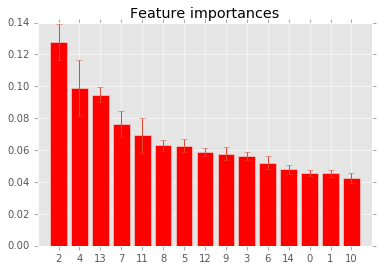

Feature ranking:
1. feature 2 (0.107289)
2. feature 4 (0.093767)
3. feature 13 (0.092703)
4. feature 7 (0.081885)
5. feature 11 (0.069523)
6. feature 5 (0.067794)
7. feature 12 (0.062252)
8. feature 9 (0.062038)
9. feature 8 (0.061919)
10. feature 3 (0.060660)
11. feature 14 (0.058348)
12. feature 1 (0.049374)
13. feature 0 (0.047801)
14. feature 6 (0.043785)
15. feature 10 (0.040864)


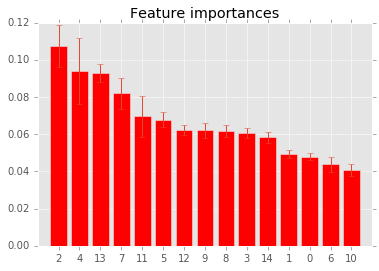

Feature ranking:
1. feature 2 (0.109654)
2. feature 4 (0.090486)
3. feature 7 (0.089837)
4. feature 13 (0.082874)
5. feature 5 (0.074306)
6. feature 9 (0.069959)
7. feature 11 (0.066659)
8. feature 8 (0.065683)
9. feature 12 (0.058269)
10. feature 3 (0.057625)
11. feature 1 (0.052744)
12. feature 14 (0.048305)
13. feature 0 (0.048000)
14. feature 6 (0.046085)
15. feature 10 (0.039515)


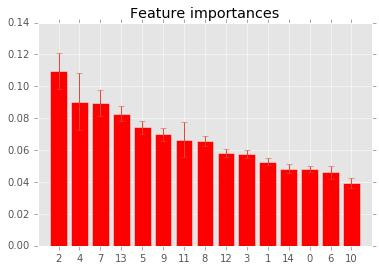

Feature ranking:
1. feature 2 (0.110902)
2. feature 4 (0.088988)
3. feature 7 (0.085677)
4. feature 13 (0.081261)
5. feature 5 (0.067800)
6. feature 8 (0.066178)
7. feature 11 (0.063827)
8. feature 9 (0.063711)
9. feature 12 (0.060126)
10. feature 3 (0.059709)
11. feature 14 (0.053141)
12. feature 1 (0.052807)
13. feature 0 (0.049580)
14. feature 6 (0.049164)
15. feature 10 (0.047129)


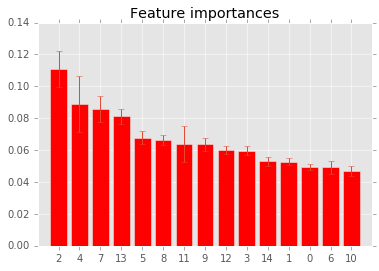

Feature ranking:
1. feature 2 (0.115372)
2. feature 4 (0.087386)
3. feature 13 (0.086993)
4. feature 7 (0.084467)
5. feature 5 (0.068668)
6. feature 8 (0.067793)
7. feature 9 (0.063955)
8. feature 11 (0.062710)
9. feature 3 (0.059598)
10. feature 12 (0.059178)
11. feature 14 (0.053289)
12. feature 1 (0.051177)
13. feature 0 (0.047596)
14. feature 6 (0.047391)
15. feature 10 (0.044427)


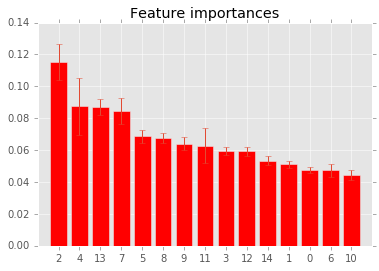

Feature ranking:
1. feature 2 (0.113759)
2. feature 4 (0.093825)
3. feature 13 (0.087337)
4. feature 7 (0.083597)
5. feature 5 (0.068737)
6. feature 11 (0.067489)
7. feature 8 (0.065526)
8. feature 9 (0.061033)
9. feature 12 (0.058875)
10. feature 3 (0.056915)
11. feature 14 (0.053665)
12. feature 6 (0.049352)
13. feature 0 (0.048745)
14. feature 1 (0.047409)
15. feature 10 (0.043737)


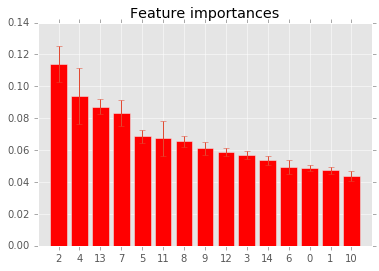

Feature ranking:
1. feature 2 (0.109170)
2. feature 4 (0.088802)
3. feature 13 (0.083447)
4. feature 7 (0.083117)
5. feature 5 (0.069395)
6. feature 11 (0.066149)
7. feature 8 (0.064922)
8. feature 9 (0.063801)
9. feature 3 (0.063378)
10. feature 12 (0.062422)
11. feature 14 (0.055414)
12. feature 1 (0.051565)
13. feature 0 (0.048388)
14. feature 6 (0.047199)
15. feature 10 (0.042831)


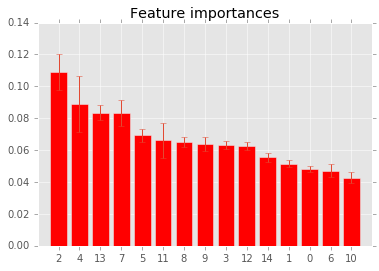

Feature ranking:
1. feature 4 (0.143367)
2. feature 11 (0.103789)
3. feature 13 (0.094278)
4. feature 2 (0.080330)
5. feature 7 (0.064020)
6. feature 5 (0.059857)
7. feature 8 (0.055858)
8. feature 3 (0.055640)
9. feature 9 (0.054977)
10. feature 12 (0.053061)
11. feature 14 (0.051645)
12. feature 0 (0.050130)
13. feature 1 (0.048429)
14. feature 6 (0.044782)
15. feature 10 (0.039837)


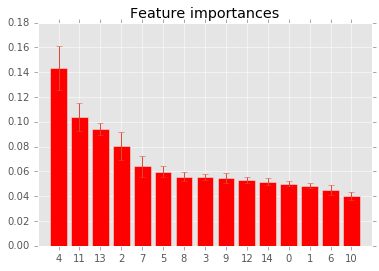

Feature ranking:
1. feature 2 (0.108068)
2. feature 4 (0.090986)
3. feature 13 (0.085802)
4. feature 7 (0.082077)
5. feature 11 (0.076961)
6. feature 5 (0.071236)
7. feature 8 (0.064227)
8. feature 12 (0.062371)
9. feature 9 (0.060856)
10. feature 3 (0.053710)
11. feature 14 (0.052997)
12. feature 1 (0.051965)
13. feature 0 (0.048793)
14. feature 6 (0.045037)
15. feature 10 (0.044913)


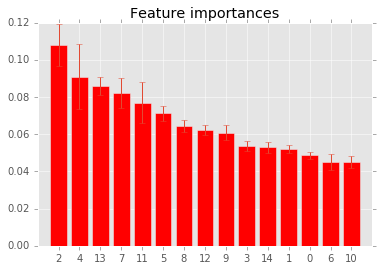

Feature ranking:
1. feature 2 (0.107792)
2. feature 4 (0.094166)
3. feature 13 (0.079915)
4. feature 11 (0.068898)
5. feature 9 (0.068772)
6. feature 7 (0.063656)
7. feature 5 (0.062196)
8. feature 8 (0.061996)
9. feature 3 (0.061981)
10. feature 12 (0.060489)
11. feature 6 (0.059614)
12. feature 14 (0.054427)
13. feature 0 (0.053913)
14. feature 10 (0.051328)
15. feature 1 (0.050856)


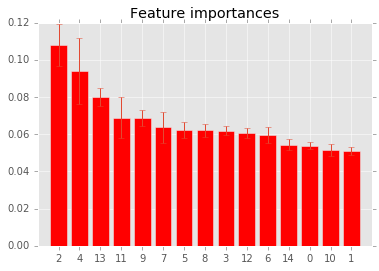

Feature ranking:
1. feature 4 (0.132414)
2. feature 13 (0.091143)
3. feature 2 (0.091105)
4. feature 11 (0.083131)
5. feature 7 (0.070311)
6. feature 5 (0.062008)
7. feature 8 (0.058974)
8. feature 9 (0.058032)
9. feature 3 (0.057745)
10. feature 12 (0.057307)
11. feature 14 (0.054157)
12. feature 1 (0.048567)
13. feature 0 (0.048276)
14. feature 6 (0.045917)
15. feature 10 (0.040911)


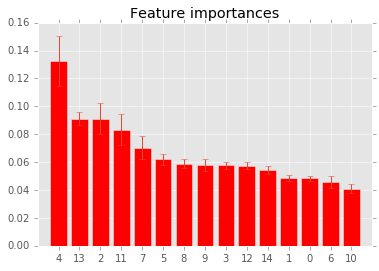

In [50]:
#plotting importances at each class
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
y = {}
for i in range(0,len(clf.estimators_)-1):
    importances = clf.estimators_[i].feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    x = {}
    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        x[f+1] = indices[f]

    # Plot the feature importances of the forest
    plt.figure()
    y[i] = x
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

In [52]:
#printing the features which seem to appear most often
column_names_train[2],column_names_train[4],column_names_train[13],column_names_train[7], 

('signup_method', 'language', 'action_detail', 'first_affiliate_tracked')

In [51]:
from sklearn import metrics

print "F1 score: %f" % metrics.f1_score(y_test, y_pred)
print "Accuracy Score: %f" % metrics.accuracy_score(y_test, y_pred)

F1 score: 0.919089
Accuracy Score: 0.898112


# Fitting the entire train set, predicting on test set
****

### Reading Test Data
****

In [28]:
test_users = pd.read_csv('data/test_users.csv')
test_set, test_user_id, column_names_test = clean_up(test_users)


Number of rows in the test set are: 4995712


In [29]:
test_set = encode_df(test_set, feature_list)
test_set = preprocessing_df(test_set, 'test', normalizers = normalizers)
test_set.shape[0]

4995712

In [30]:
X_test_pca = pca.transform(test_set)

In [31]:
#training on the entire train set
t0 = time()
clf = OneVsRestClassifier(RandomForestClassifier(bootstrap = True, random_state=0, n_jobs = -1))
print "done in %0.3fs" % (time() - t0)

t0= time()
clf.fit(X_train_pca, train_labels_set)
print "done in %0.3fs" % (time() - t0)

t0 = time()
#predict probabilities of each country
y_pred = clf.predict_proba(X_test_pca)
print "done in %0.3fs" % (time() - t0)

done in 0.178s
done in 2707.026s
done in 84.646s


### Submission format
****

In [32]:
#since the predictions need to be on a user level, we need to average out the probabilities
last_df = pd.concat([test_user_id,pd.DataFrame(y_pred, columns = encoded_dummies.columns)], axis = 1)
last_df = last_df.groupby('user_id').mean().reset_index()

last_df.head()


,user_id,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
0,0010k6l0om,0.000000,0.015873,0.000000,0.014286,0.023810,0.003175,0.096825,0.753968,0.000000,0.0000,0.407937,0.190476
1,0031awlkjq,0.000000,0.125000,0.025000,0.187500,0.075000,0.075000,0.025000,0.487500,0.025000,0.0625,0.375000,0.225000
2,00378ocvlh,0.000000,0.039556,0.000000,0.026667,0.108000,0.010667,0.002667,0.473333,0.000000,0.0000,0.423111,0.092000
3,0048rkdgb1,0.038501,0.100000,0.023913,0.141449,0.089130,0.058696,0.080435,0.542391,0.028261,0.0000,0.377852,0.247826
4,0057snrdpu,0.014286,0.035714,0.003571,0.121429,0.078571,0.121429,0.111508,0.557143,0.010714,0.0000,0.439286,0.096429


In [33]:
import operator

ids = []
result = {}
for index, row in last_df.iterrows():
    country_values = row[1:].to_dict()
    sorted_vals = sorted(country_values.items(), key=operator.itemgetter(1), reverse = True)[:5]
    result[row[0]]= sorted_vals

In [34]:
some_other_df = pd.DataFrame(result).T
some_other_df.head()

,0,1,2,3,4
0010k6l0om,"(NDF, 0.753968253968)","(US, 0.407936507937)","(other, 0.190476190476)","(IT, 0.0968253968254)","(FR, 0.0238095238095)"
0031awlkjq,"(NDF, 0.4875)","(US, 0.375)","(other, 0.225)","(ES, 0.1875)","(CA, 0.125)"
00378ocvlh,"(NDF, 0.473333333333)","(US, 0.423111111111)","(FR, 0.108)","(other, 0.092)","(CA, 0.0395555555556)"
0048rkdgb1,"(NDF, 0.542391304348)","(US, 0.377852437418)","(other, 0.247826086957)","(ES, 0.141449275362)","(CA, 0.1)"
0057snrdpu,"(NDF, 0.557142857143)","(US, 0.439285714286)","(GB, 0.121428571429)","(ES, 0.121428571429)","(IT, 0.111507936508)"


In [ ]:
pd.DataFrame(some_other_df.unstack(0))\
.reset_index()\
.sort_values(['level_1','level_0'])[['level_1',0]].to_csv('submission_format.csv', index = False)

### This returns a score of 84.86% accuracy after submitting on Kaggle.